### Анализ данных в задаче кредитного скоринга
В этом задании необходимо проанализировать данные для задачи кредитного скоринга. Описание признаков:
- ```LIMIT_BAL```:  размер кредитного лимита (в том числе и на семью клиента)
- ```SEX```: пол клиента (1 = мужской, 2 = женский)
- ```EDUCATION```: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных )
- ```MARRIAGE```: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
- ```AGE```: возраст в годах
- ```PAY_0 - PAY_6```: История прошлых платежей по кредиту (PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- ```BILL_AMT1 - BILL_AMT6```:  задолженность (BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь)
- ```PAY_AMT1 - PAY_AMT6```: сумма уплаченная в (PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре)
- ```default``` - индикатор невозврата денежных средств

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import scipy 

from scipy import stats

sns.set_style('darkgrid')

In [3]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:
- a) Равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
- b) Равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения?

In [4]:
# Отберем гурппы
default_group = data[data['default'] == 1]
return_group = data[data['default'] == 0]

print('Default Group Size: ', default_group.shape[0])
print('Return Group Size: ', return_group.shape[0])

Default Group Size:  6636
Return Group Size:  23364


LIMIT_BAL Median (Default Group):  90000.0
LIMIT_BAL Median (Return Group):  150000.0


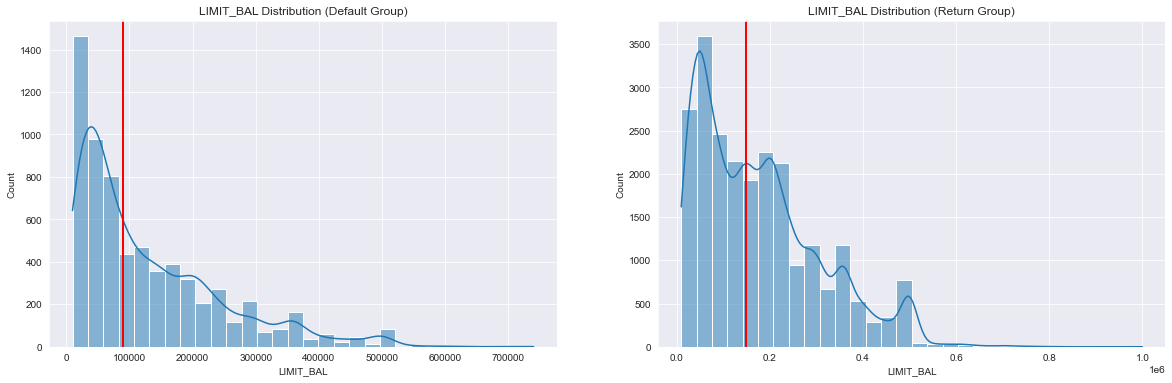

In [5]:
# Отберем медианы в группах 
median_limit_default = default_group['LIMIT_BAL'].median()
median_limit_return = return_group['LIMIT_BAL'].median()

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.histplot(default_group['LIMIT_BAL'], bins=30, kde=True)
plt.axvline(median_limit_default, color='r', linewidth=2)
plt.title('LIMIT_BAL Distribution (Default Group)')

plt.subplot(1,2,2)
sns.histplot(return_group['LIMIT_BAL'], bins=30, kde=True)
plt.axvline(median_limit_return, color='r', linewidth=2)
plt.title('LIMIT_BAL Distribution (Return Group)');

print('LIMIT_BAL Median (Default Group): ', median_limit_default)
print('LIMIT_BAL Median (Return Group): ', median_limit_return)

Распределения признака ```LIMIT_BAL``` в обоих группах явно отличается от нормального, медианы отличаются, и скорее всего значимо.

### Оценка равенства медианных значений кредитного лимита (интервальная оценка)
В качестве интервальной оценки воспользуемся бутстрепом

In [6]:
# Определим ряд функций для получения псевдовыборок на основе бутстрепа и получение ДИ
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

# Получим псевдовыборки из медиан для каждой группы 
bootstrap_medians_default = list(map(np.median, get_bootstrap_samples(default_group['LIMIT_BAL'].values, 1000)))
bootstrap_medians_return = list(map(np.median, get_bootstrap_samples(return_group['LIMIT_BAL'].values, 1000)))

# Получим ДИ для полученных псевдовыборок
print("95% Сonfidence Interval (Default Group):",  stat_intervals(bootstrap_medians_default))
print("95% Confidence Interval (Return Group):",  stat_intervals(bootstrap_medians_return))

95% Сonfidence Interval (Default Group): [80000. 90000.]
95% Confidence Interval (Return Group): [150000. 150000.]


ДИ не пересекаются, медианы значимо отличаются друг от друга. Кредитный лимит у группы возврата больше. Оценим точечно.

In [7]:
print('Median Difference Between Groups: ', abs(median_limit_default - median_limit_return))

Median Difference Between Groups:  60000.0


Интервальная оценка разности медиан

In [8]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(bootstrap_medians_default, bootstrap_medians_return)))
print("95% Confidence Interval For the Difference Between Medians",  stat_intervals(delta_median_scores, 0.05))

95% Confidence Interval For the Difference Between Medians [60000. 70000.]


ДИ для разности медиан двух групп не содержит ноль. Гипотезу о равенстве медиан можно уверенно отвергнуть. Группы значимо отличаются друг от друга.

### Проверка равенства распределений 2-х групп

Будем применять **Перестановочный Критерий (независимые выборки)**

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Нулевая гипотеза состоит в том, что функции распределения для первой и второй выборки одинаковы. Они совпадают. Альтернатива следующая: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке. Воспользуемся еже реализованными ранее в курсе функциями 

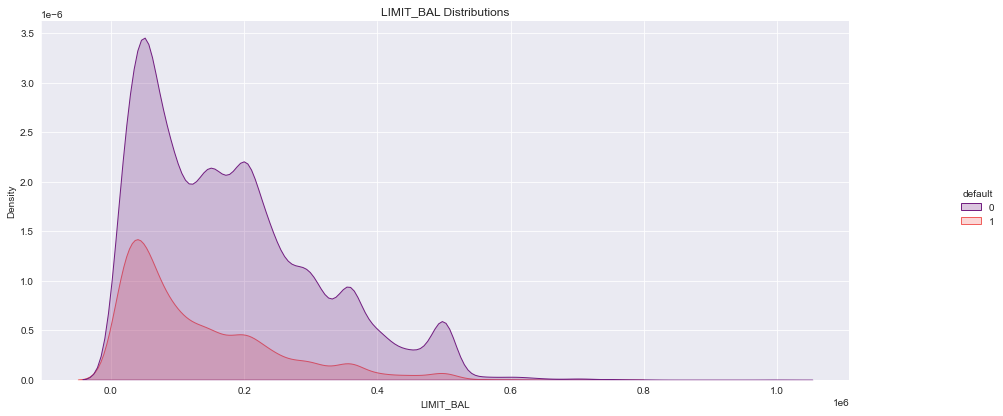

In [9]:
sns.displot(data, x='LIMIT_BAL', hue='default', kind='kde', fill=True, palette='magma')
plt.title('LIMIT_BAL Distributions')
plt.gcf().set_size_inches(15, 6);

In [10]:
# Расчет t - статистики для независимых выборок
def permutation_t_stat_ind(sample_1, sample_2):
    return sample_1.mean() - sample_2.mean()

# Функция генерирования индексов для разбиения данных на первую и вторую выборку случайным образом
def get_random_combinations(n1, n2, max_combinations):
    
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
        
    return [(index[:n1], index[n1:]) for index in indices]

# Генерация распределения
def get_permutation_zero_distr_ind(sample_1, sample_2, max_combinations = None):
    # Объединим выборки в одну и рассчитаем необходимые параметры
    joined_sample = np.hstack((sample_1, sample_2))
    
    n_1 = len(sample_1)
    n_2 = len(sample_2)
    n = len(joined_sample)
    
    # Если нам задано ограничение на максимальное количество комбинаций, 
    # то сгенерируем индексы для разбиения данных на первую и вторую выборку случайным образом
    if max_combinations:
        indices = get_random_combinations(n_1, n_2, max_combinations)
        
    # Иначе явно перебираем все возможные комбинации 
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n_1)]
        
    # построим разделение нашей выборки на две по соответствующим индексам 
    # Далее рассчитаем нужную статистику, то есть разницу средних по полученным разбиениям
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    
    return distr

# Получение p-value
def get_p_value_permutation_test_2sample_ind(sample_1, sample_2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError ('Alternative Not Recognized!!!')
        
    t_stat = round(permutation_t_stat_ind(sample_1, sample_2), 4)
    zero_distribution = get_permutation_zero_distr_ind(sample_1, sample_2, max_permutations)
    
    if alternative == 'two-sided':
        return t_stat, round(sum([1 if abs(x) >= abs(t_stat) else 0 for x in zero_distribution]) / len(zero_distribution), 6)
    
    if alternative == 'less':
        return t_stat, round(sum([1 if x <= t_stat else 0 for x in zero_distribution]) / len(zero_distribution), 6)

    if alternative == 'greater':
        return t_stat, round(sum([1 if x >= t_stat else 0 for x in zero_distribution]) / len(zero_distribution), 6)

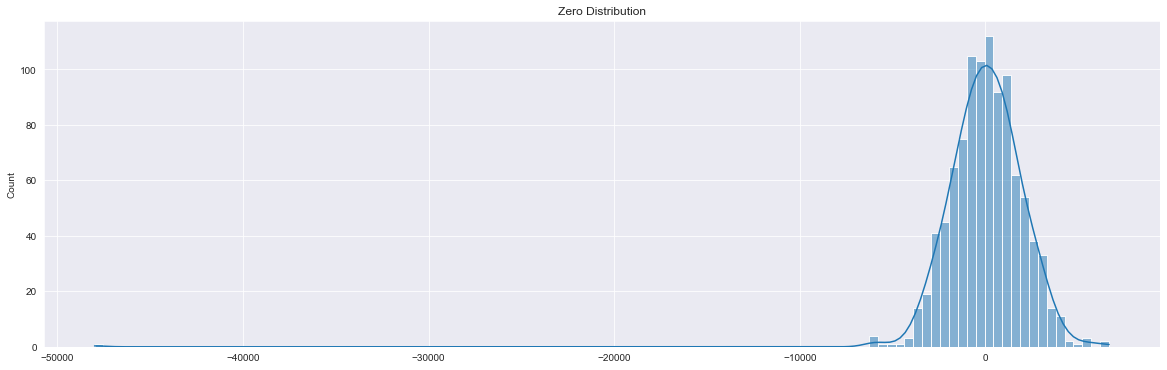

In [11]:
# Взглянем на нулевое распределение
plt.figure(figsize=(20,6))
sns.histplot(get_permutation_zero_distr_ind(default_group['LIMIT_BAL'].values, return_group['LIMIT_BAL'].values, max_combinations = 1000), kde=True)
plt.title('Zero Distribution');

In [12]:
# p-value для 10к перестановок
test_res = get_p_value_permutation_test_2sample_ind(
    sample_1 = default_group['LIMIT_BAL'].values,
    sample_2 = return_group['LIMIT_BAL'].values,
    max_permutations = 10000,
    alternative = 'two-sided'
)
print(f'Statistics: {test_res[0]}, p-value: {test_res[1]}')

Statistics: -47990.0697, p-value: 0.0


Нулевая гипотеза уверенно отвергается, распределения значимо отличаются друг от друга. Следовательно, клиенты запрашивающие кредиты на отностительно небольшие суммы (ДИ 80-90 тыс.) должны попадать в группу риска.

### Задание 2 
Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

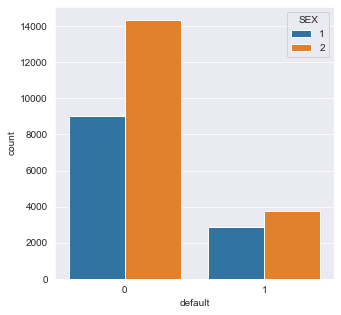

In [13]:
plt.figure(figsize=(5,5))
sns.countplot(x='default', hue='SEX', data=data);

График показывает, что гендерный состав групп вернувших и не вернувших кредит отличается, и скорее всего даже значимо. 


Проверим гипотезу гипотезу о совпадении гендерного состава в обоих выборках. Предполагаем, что выборки имеют распределения Бернулли с распределениями $Ber(p1)$ и $Ber(p2)$

$H_0\colon p1 = p2$: гендерный состав групп совпадает

$H_1\colon p1\neq p2$: гендерный состав групп отличается

In [14]:
# Отберем группы 
gender_default = data[data['default'] == 1]['SEX']
gender_return = data[data['default'] == 0]['SEX']

print('Default Group (Gender) Size: ', gender_default.shape[0])
print('Return Group (Gender) Size: ', gender_return.shape[0])

Default Group (Gender) Size:  6636
Return Group (Gender) Size:  23364


Для проврки гипотезы воспользуемся **доверительным интервалом для разности долей (независимые выбороки)**

$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$

$$p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [15]:
# Реализация формулы выше
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)


# Так как значения признаков должны быть бинарными, то преобразуем их к 0-1
gender_default = list((map(lambda x: 0 if x == 2 else 1 , gender_default)))
gender_return = list((map(lambda x: 0 if x == 2 else 1 , gender_return)) )                  

In [16]:
print("Confidence Interval: [%.4f, %.4f]" % proportions_confint_diff_ind(gender_default, gender_return))

Confidence Interval: [0.0336, 0.0605]


ДИ не содержит нуля, следовательно, гендерный состав групп вернувших кредит и не вернувших кредит различный. Для проверки гипотезы с помощью статистического критерия применим точный тест Фишера, который не имеет ограничений, в отличии от критерия хи-квадрат.

In [17]:
# Получим таблицу сопряженности
gender_table = data.pivot_table(index='default', values="LIMIT_BAL", columns='SEX', aggfunc = len, fill_value=0)
gender_table.head()

SEX,1,2
default,,
0,9015,14349
1,2873,3763


In [18]:
odds_ratio, p_value = scipy.stats.fisher_exact(gender_table.values, alternative='two-sided')
print('Odds Ration: %.2f' %odds_ratio)
print('P-Value: %s' %p_value)

Odds Ration: 0.82
P-Value: 5.2528380520530976e-12


Гипотеза о равенстве гендерных групп отвергается, обнаружена практическая значимость. Среди не вернувших кредит больше женщин.


### Задание 3
Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.
- Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости?
- Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг? наоборт, не отдаст долг?

In [28]:
educ_labels = ["Ph.D.", "Master", "Bachelor", "Graduate school", "Elementary education", "N/A"]

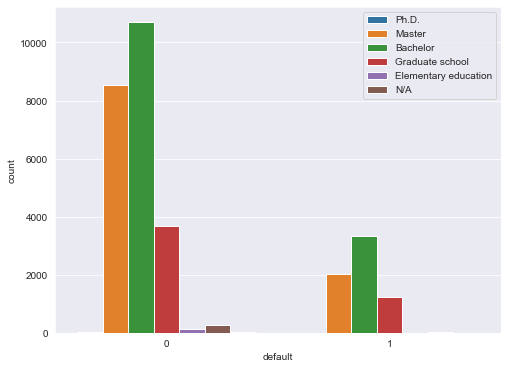

In [31]:
plt.figure(figsize=(8,6))
sns.countplot(x='default', hue='EDUCATION', data=data)
plt.legend(educ_labels);

In [20]:
# Отберем группы
educ_default = data[data['default'] == 1]['EDUCATION']
educ_return = data[data['default'] == 0]['EDUCATION']

In [21]:
# Создадим таблицу сопряженности
educ_table = data.pivot_table(index='default', columns='EDUCATION', values='LIMIT_BAL', aggfunc=len, fill_value=0)
educ_table.head()

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


Проверку гипотезы будем осуществлять с помощью критерия хи-квадрат. Данный критерий обладает рядом требований которые должны быть выполнены:
- Число объектов в таблице сопряженности $n \geq 40$ 
- Ожидаемое количество элементов в таблице меньше 5 не более, чем в 20% случаев

In [72]:
print('Количество наблюдений в таблице сопряженности: ', educ_table.values.sum())
print('Доля случаев где число наблюдений меньше 5: ', (educ_table.values < 5).sum()/(educ_table.shape[0]*educ_table.shape[1]))

Количество наблюдений в таблице сопряженности:  30000
Доля случаев где число наблюдений меньше 5:  0.07142857142857142


Отлично, требования выполняются, сформулируем гипотезы

$H_0$: уровень образования не влияет на возврат кредита

$H_1$: влияет

In [56]:
chi2_test_results = stats.chi2_contingency(educ_table.values)
print(f'Chi2 value: %.4f P-value: %.4f: ' %(chi2_test_results[0], chi2_test_results[1]))

Chi2 value: 163.2166 P-value: 0.0000: 


Обнаружены статистически значимые различия, уровень образования влияет на выдачу кредита. Визуализируем разницу в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших кредит.

In [76]:
# Из проведенного теста определим ожидаемы значения
expected_values = chi2_test_results[3]

# Определим разницу между ожидаемыми и наблюдаемыми значениями частот 
educ_diff_table = pd.DataFrame(data=expected_values-educ_table.values, columns=educ_table.columns, index=['default=0', 'default=1'])
educ_diff_table

EDUCATION,0,1,2,3,4,5,6
default=0,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812
default=1,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812


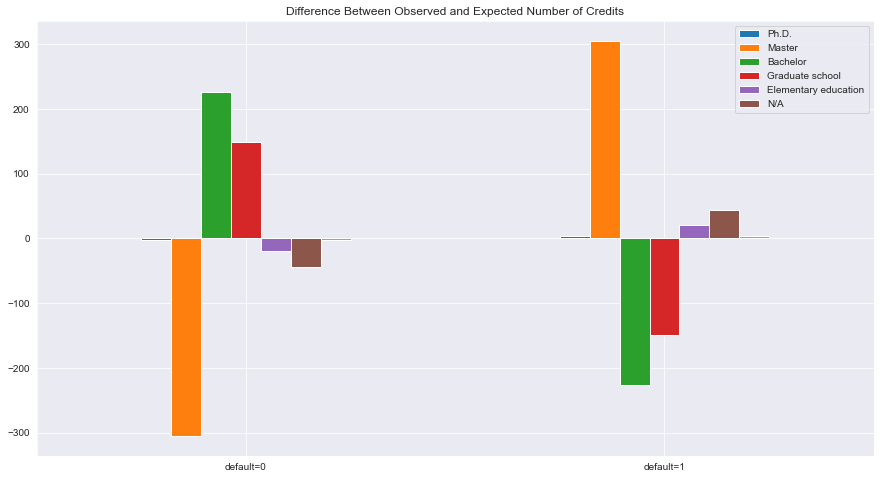

In [95]:
# Визуализируем
educ_diff_table.plot(kind='bar', rot=0, figsize=(15,8))
plt.title('Difference Between Observed and Expected Number of Credits')
plt.legend(educ_labels);

Визуализируем разность между количеством человек вернувших и не вернувших кредит по каждому значению образования для наших групп.

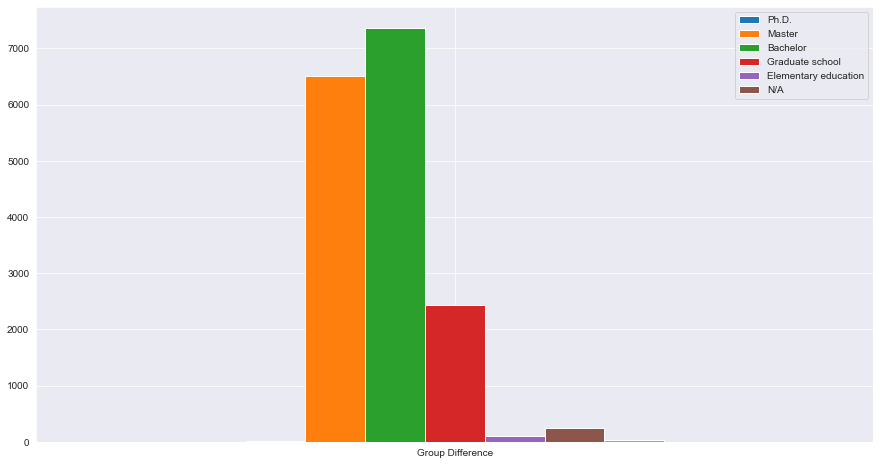

In [97]:
educ_diff_table_2 = pd.DataFrame(data=(educ_table.loc[0] - educ_table.loc[1]).values.reshape(1,7),
                                 columns=educ_table.columns, index=['Group Difference'])

# Визуализируем
educ_diff_table_2.plot(kind='bar', rot=0, figsize=(15,8))
plt.legend(educ_labels);

Для того чтобы не потерять интерпретируемость и привести значения к одному масштабу необходимо нормировать каждое полученное нами значение разности на количество людей в группе (чем больше значение, тем больше доля людей вернувших кредит)

In [101]:
educ_diff_table_2_scaled = educ_diff_table_2/(educ_table.loc[0]+educ_table.loc[1])
educ_diff_table_2_scaled.index = ['Group Difference Scaled']
educ_diff_table_2_scaled

EDUCATION,0,1,2,3,4,5,6
Group Difference Scaled,1.0,0.615305,0.525303,0.496848,0.886179,0.871429,0.686275


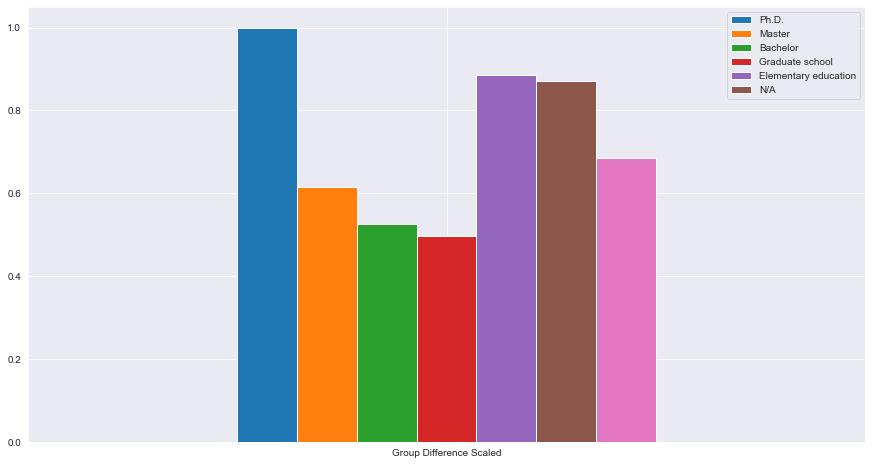

In [102]:
# Визуализируем
educ_diff_table_2_scaled.plot(kind='bar', rot=0, figsize=(15,8))
plt.legend(educ_labels);

Данный график показывает, что "школьники" и бакалавры в группе риска, а люди с магистерской степенью или докторской чаще возвращают кредиты.

### Задание 4
Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

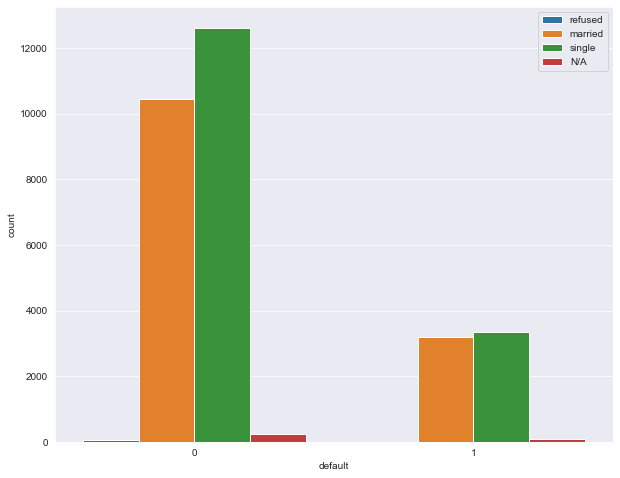

In [109]:
marriage_labels = ["refused", "married", "single", "N/A"]

plt.figure(figsize=(10,8))
sns.countplot(data=data, hue='MARRIAGE', x='default')
plt.legend(marriage_labels);

In [111]:
# Таблица сопряженности
marriage_table = pd.pivot_table(data=data,
                                values='LIMIT_BAL',
                                index='default',
                                columns='MARRIAGE',
                                aggfunc= len,
                                fill_value=0)
marriage_table

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


Проверим требоания для хи-квадрат

In [115]:
print('Количество наблюдений в таблице сопряженности: ', marriage_table.values.sum())
print('Доля случаев где число наблюдений меньше 5: ', (marriage_table.values < 5).sum()/(marriage_table.shape[0]*marriage_table.shape[1]))

Количество наблюдений в таблице сопряженности:  30000
Доля случаев где число наблюдений меньше 5:  0.0


Трбования выполняются. Посчитаем значение хи-квадрат

In [116]:
chi2_test_results = stats.chi2_contingency(marriage_table.values)
print(f'Chi2 value: %.4f P-value: %.4f: ' %(chi2_test_results[0], chi2_test_results[1]))

Chi2 value: 35.6624 P-value: 0.0000: 


Обнаружены значимые различия. Для выявления взаимосвязи применим V-крамера для определения значения корреляции

In [123]:
n_samples = marriage_table.sum().sum()
v_cr_value = (chi2_test_results[0]/n_samples)**0.5
print('V-Cramer Value: %.4f' %v_cr_value)

V-Cramer Value: 0.0345


Численная мера- корреляция, однако не очень большая.

### Задание 5
Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:
- a) Равенство медианных значений возрастов людей
- b) Равенство распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения ?

In [129]:
# Отберем группы 
age_default = data[data['default'] == 1]['AGE']
age_return = data[data['default'] == 0]['AGE']

# Медианы возрастов в группах 
median_age_default = age_default.median()
median_age_return = age_return.median()

Age Median (Default Group):  34.0
Age Median (Return Group):  34.0


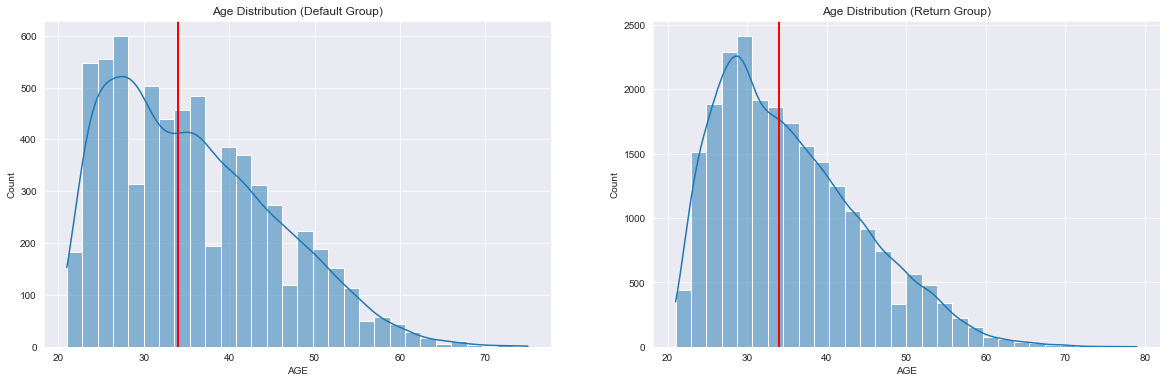

In [131]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.histplot(age_default, bins=30, kde=True)
plt.axvline(median_age_default, color='r', linewidth=2)
plt.title('Age Distribution (Default Group)')

plt.subplot(1,2,2)
sns.histplot(age_return, bins=30, kde=True)
plt.axvline(median_age_return, color='r', linewidth=2)
plt.title('Age Distribution (Return Group)');

print('Age Median (Default Group): ', median_age_default)
print('Age Median (Return Group): ', median_age_return)

Распределения возрастов людей в группах отличаются от нормального. Сформируем необходимые гипотезы:

$H_0$: возрас не влияет на возврат 

$H_1$: влияет

In [132]:
# Получим псевдовыборки из медиан для каждой группы 
bootstrap_medians_default = list(map(np.median, get_bootstrap_samples(age_default.values, 1000)))
bootstrap_medians_return = list(map(np.median, get_bootstrap_samples(age_return.values, 1000)))

# Получим ДИ для полученных псевдовыборок
print("95% Сonfidence Interval (Default Group):",  stat_intervals(bootstrap_medians_default))
print("95% Confidence Interval (Return Group):",  stat_intervals(bootstrap_medians_return))

95% Сonfidence Interval (Default Group): [34. 35.]
95% Confidence Interval (Return Group): [34. 34.]


ДИ данных выборок пересекаются и причем существенно. Построим доверительный интервал для разности медиан.

In [136]:
print('Median Difference Between Groups: ', abs(median_age_default - median_age_return))

Median Difference Between Groups:  0.0


C большой вероятностью значимых отличий между группами нет.

Проверим, построив ДИ для разности медиан (интервальная оценка разности медиан). Если такой интервал будет содержать ноль, значит мы правы.

In [137]:
group_median_differences = np.array(bootstrap_medians_default) - np.array(bootstrap_medians_return)
print("95% Confidence Interval For the Difference Between Medians",  stat_intervals(group_median_differences, 0.05))

95% Confidence Interval For the Difference Between Medians [0. 1.]


Значимых отличий между медианами возрастов для двух групп нет. Значимых отличий между 2-мя данными группами нет.

Для проверки равенства средних можно воспользоваться критерием Манна-Уитни со следующими гипотезами:

$H_0$: средние равны

$H_1$: средние не равны

In [139]:
stat_value, p_value = stats.mannwhitneyu(age_default, age_return)
print('Manna-Uitni Test: Statistic: %d p-value: %.4f' %(stat_value, p_value))

Manna-Uitni Test: Statistic: 76966879 p-value: 0.1863


Средние равны, значит возраст не влияет на возврат/не возврат кредита. Распределения возраста для 2-х групп очень похожи между самой и мы уже статистически доказали, что они значимо не отличаются друг от друга.

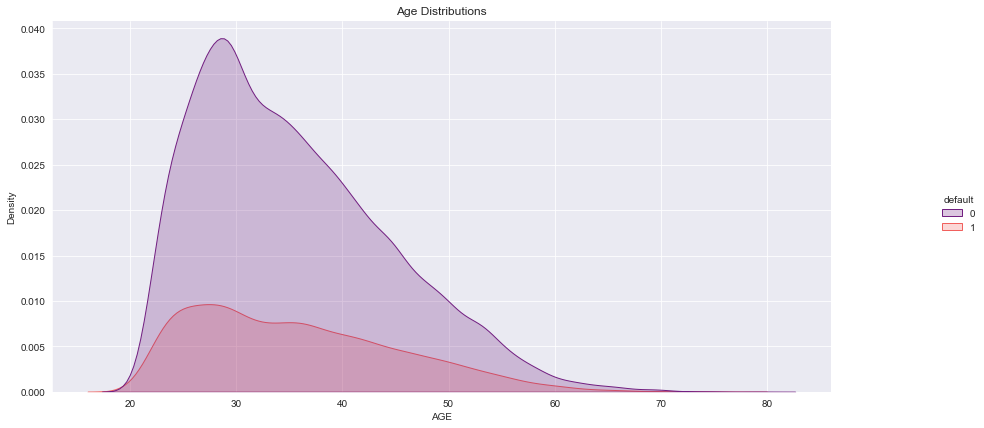

In [141]:
sns.displot(data, x='AGE', hue='default', kind='kde', fill=True, palette='magma')
plt.title('Age Distributions')
plt.gcf().set_size_inches(15, 6);